# FrozenLake-v1 환경을 통한 RL 기초 코드 실습

FrozenLake open-ai gym: https://gym.openai.com/envs/FrozenLake-v0/  

[구현 source code](https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py)  


Agent는 빙판으로 가정된 grid world에서 움직인다. Starting point, Goal, Frozen sruface, Hole의 4가지 상황이 있는데, agent의 목적은 starting point에서 시작해 goal로 가는 것이다. 매 에피소드는 2가지 상황에서 종료되는데, goal에 도착했을 경우와 hole에 도착해서 물에 빠지는 경우이다. Hole을 제외한 타일은 빙판이므로, agent가 이동 방향을 결정했더라도 미끄러져 다른 방향으로 이동할 수도 있다. (Agent는 항상 의도한 방향으로 움직이는 것은 아니다)

4x4, 8x8 map이 있으며 아래는 4x4 map의 예시이다.  

```
SFFF       (S: starting point, safe)  
FHFH       (F: frozen surface, safe)  
FFFH       (H: hole, fall to your doom)  
HFFG       (G: goal, where the frisbee is located)  
```

State: 0 ~ 15 사이의 값으로 agent의 위치를 표현한다. (맨 왼쪽 맨 위부터 0으로 시작해 오른쪽으로 1, 2, 3.. 그 다음 라인은 4, 5, 6, 7 ..)  
Action: 0 ~ 3 사이의 값으로 agent가 이동할 방향을 표현한다. (Left, Down, Right, Up)  
Reward: Goal에 도착하면 1을 반환하며 다른 상태에서는 0을 반환한다.  
Done: agnet가 Goal, Hole에 도착할 때 True를 반환하고 다른 타일에 있을 때는 False를 반환한다.  


---


## Library Import

In [1]:
import gym
import numpy as np

## 환경 만들기

is_slippery
- Agent가 이동할 때 미끄러질 수 있는지 선택
- True 입력시 Transition probability가 Stochastic한 환경으로, False 입력시 deterministic한 환경으로 세팅

`env.render()` 함수를 통해 현재 환경의 상황을 출력한다.

In [2]:
env = gym.make('FrozenLake-v1', is_slippery=False)

env.render()


SFFF
FHFH
FFFH
HFFG


### 주요 함수

`env.reset()` 함수를 통해 환경을 처음 상태로 초기화 할 수 있다.  

`env.step(action)` action을 수행한 후, next state, reward, done, transition probability 정보를 반환한다.


In [3]:
direction = {0:'Left', 1:'Down', 2:'Right', 3:'Up'}

for action in range(env.action_space.n): # env.action_space.n = action의 수
    env.reset()
    
    print("\nAgent가 움직이는 방향: {}".format(direction[action]))
    new_state, reward, done, info = env.step(action)
    
    print('new_state:{}, reward:{}, done:{}, info:{}'.format(new_state, reward, done, info))
    env.render()


Agent가 움직이는 방향: Left
new_state:0, reward:0.0, done:False, info:{'prob': 1.0}
  (Left)
SFFF
FHFH
FFFH
HFFG

Agent가 움직이는 방향: Down
new_state:4, reward:0.0, done:False, info:{'prob': 1.0}
  (Down)
SFFF
FHFH
FFFH
HFFG

Agent가 움직이는 방향: Right
new_state:1, reward:0.0, done:False, info:{'prob': 1.0}
  (Right)
SFFF
FHFH
FFFH
HFFG

Agent가 움직이는 방향: Up
new_state:0, reward:0.0, done:False, info:{'prob': 1.0}
  (Up)
SFFF
FHFH
FFFH
HFFG


`env.P[state][action]` agent가 특정 state에서 특정 action을 수행한다고 했을 때, 상태가 나타날 확률

In [4]:
# policy

env = gym.make('FrozenLake-v1', is_slippery=False)

env.P[6]

{0: [(1.0, 5, 0.0, True)],
 1: [(1.0, 10, 0.0, False)],
 2: [(1.0, 7, 0.0, True)],
 3: [(1.0, 2, 0.0, False)]}

In [5]:
# policy

env = gym.make('FrozenLake-v1', is_slippery=True)

env.P[6]

{0: [(0.3333333333333333, 2, 0.0, False),
  (0.3333333333333333, 5, 0.0, True),
  (0.3333333333333333, 10, 0.0, False)],
 1: [(0.3333333333333333, 5, 0.0, True),
  (0.3333333333333333, 10, 0.0, False),
  (0.3333333333333333, 7, 0.0, True)],
 2: [(0.3333333333333333, 10, 0.0, False),
  (0.3333333333333333, 7, 0.0, True),
  (0.3333333333333333, 2, 0.0, False)],
 3: [(0.3333333333333333, 7, 0.0, True),
  (0.3333333333333333, 2, 0.0, False),
  (0.3333333333333333, 5, 0.0, True)]}

# Solve by Dynamic Programming

MDP에서 완벽한 environment의 model이 주어졌을 때 dynamic programming으로 optimal policy를 계산할 수 있다.  
이를 위해 value function을 잘 구조화 하는 것이 중요하다.  

## Ex 1. Implement the state-value iteration for policy evaluation.  

Bellman Expectation Equation: State-value function  
policy에 대한 true state value function 구하기

- uniformly random policy 사용
- 초기값은 0을 사용
- 가장 큰 value 값의 차이가 threshold(theta)보다 작은 경우 iteration 끝
- Backup: 이전 시점의 값으로 현재 시점의 값을 구하는 과정
- in-place update

`env.nS` number of states  
`env.nA` number of actions  

The Bellman update
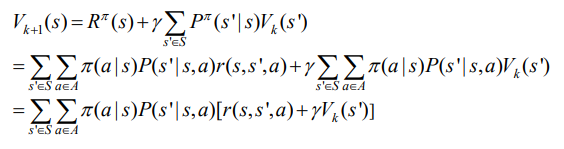
$V_k$는 k가 무한으로 갈 때, $V_{\pi}$로 수렴한다.

In [6]:
def policy_evaluation(policy, env, discount_factor=1.0, theta=0.00001):
    
    # state value function initialize
    V = np.zeros(env.nS)
    
    while True:
        delta = 0
        
        # 모든 state에 대해 탐색
        for state in range(env.nS):
            v = 0
            
            # 현재 state에서 수행하는 policy array - 각 action을 수행할 확률
            for action, action_prob in enumerate(policy[state]):
                
                # Backup
                for  transition_prob, next_state, reward, done in env.P[state][action]:
                    v = v + action_prob * transition_prob * (reward + discount_factor * V[next_state])
                    
            delta = max(delta, np.abs(v - V[state]))
            V[state] = v
            
        if delta < theta:
            break
            
    return np.array(V)

In [7]:
env = gym.make('FrozenLake-v1', is_slippery=True)

# random policy: 모든 action선택에 대한 확률이 동일함
random_policy = np.ones([env.nS, env.nA]) / env.nA

v = policy_evaluation(random_policy, env)

print("state value function")
for state in range(env.nS):
    print("State({}):\t{}".format(state, v[state]))

state value function
State(0):	0.013911000938560188
State(1):	0.011614240526169326
State(2):	0.02094062298686688
State(3):	0.010467579492152457
State(4):	0.016234776849979503
State(5):	0.0
State(6):	0.04074773601524072
State(7):	0.0
State(8):	0.03479960929625217
State(9):	0.08816698094862553
State(10):	0.14205098894184118
State(11):	0.0
State(12):	0.0
State(13):	0.17581855329406945
State(14):	0.43928969525985223
State(15):	0.0


## Ex2. Implement the Q-value iteration 

Bellman Expectation Equation: Q-value function  


The optimal Q-Bellman update

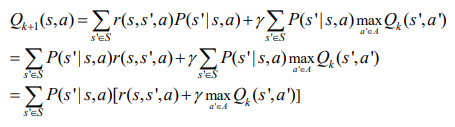

$Q_k$는 k가 무한으로 갈 때, $Q_{\pi}$로 수렴한다.

In [8]:
def Q_value_iteration(env, discount_factor=1.0, theta=0.00001):
    
    # Initialize action value function
    Q = np.zeros([env.nS, env.nA])
    
    while True:
        delta = 0
        
        # 모든 state에 대해 탐색
        for state in range(env.nS):
            q = np.zeros(env.nA)
            
            # action에 대해 탐색
            for action in range(env.nA):
                
                # Backup
                for  transition_prob, next_state, reward, done in env.P[state][action]:
                    q[action] = q[action] + transition_prob * (reward + discount_factor * np.max(Q[next_state]))
                delta = max(delta, np.abs(q[action] - Q[state][action]))
                
            for i in range(env.nA):
                Q[state][i] = q[i]
                
        if delta < theta:
            break
            
    return np.array(Q)

In [9]:
env = gym.make('FrozenLake-v1', is_slippery=True)

q = Q_value_iteration(env)

print("Action value Function(Q):")
for state in range(env.nS):
    print("State({}): {}".format(state, q[state]))

Action value Function(Q):
State(0): [0.82336142 0.82334241 0.82334241 0.82333659]
State(1): [0.54888666 0.54887345 0.5488525  0.82330631]
State(2): [0.72528616 0.72527944 0.72526365 0.823268  ]
State(3): [0.54883559 0.54883559 0.54882584 0.82324851]
State(4): [0.82337832 0.54892451 0.54892063 0.5489115 ]
State(5): [0. 0. 0. 0.]
State(6): [0.52929722 0.25487455 0.52929722 0.27442267]
State(7): [0. 0. 0. 0.]
State(8): [0.54892626 0.54894534 0.54893796 0.82340479]
State(9): [0.56856417 0.82343872 0.54897046 0.52934281]
State(10): [0.76462641 0.588194   0.49014683 0.45091198]
State(11): [0. 0. 0. 0.]
State(12): [0. 0. 0. 0.]
State(13): [0.56857548 0.60781034 0.88228991 0.588194  ]
State(14): [0.86268653 0.9411444  0.90192323 0.88230544]
State(15): [0. 0. 0. 0.]


In [10]:
state = env.reset()
done = False

print("Start")
env.render()

while not done:
    # Greedy Policy
    action = np.argmax(q[state])
    new_state, reward, done, info = env.step(action)
    print()
    env.render()
    state = new_state

Start

SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
H

## Ex3. Implement the policy iteration

Find the optimal policy by policy iteration  

Policy improvement
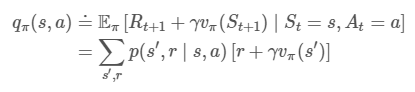

In [11]:
def policy_evaluation(env, policy, discount_factor = 1.0):
    value_table = np.zeros(env.observation_space.n)
    threshold = 1e-10
    
    while True:
        updated_value_table = np.copy(value_table)
        delta = 0
        
        for state in range(env.observation_space.n):
            action = policy[state]
            v = 0
            for trans_prob, next_state, reward, done in env.P[state][action]:
                v += trans_prob * (reward + discount_factor * updated_value_table[next_state])
        
            delta = max(delta, abs(updated_value_table[state] - v))
            value_table[state] = v
            
        if delta <= threshold:
            break
    
    return value_table

def policy_improvement(env, value_table, discount_factor):
    policy = np.zeros(env.observation_space.n)
    
    for state in range(env.observation_space.n):
        Q_table = np.zeros(env.action_space.n)
        
        for action in range(env.action_space.n):
            
            for trans_prob, next_state, reward, done in env.P[state][action]:
                Q_table[action] += trans_prob * (reward + discount_factor * value_table[next_state])
            
        policy[state] = np.argmax(Q_table)

    return policy
        

def policy_iteration(env, discount_factor = 1.0):
    random_policy = np.zeros(env.observation_space.n) # state x action
    step = 200000
    
    for i in range(step):
        new_value_function = policy_evaluation(env, random_policy, discount_factor)
        new_policy = policy_improvement(env, new_value_function, discount_factor)
        
        if(np.all(random_policy == new_policy)):
            print('Policy iteration converged at step {}'.format(i+1))
            break
        
        random_policy = new_policy
        
    return new_policy

In [12]:
env = gym.make('FrozenLake-v1', is_slippery=True)

optimal_policy = policy_iteration(env, discount_factor=0.9).astype(int)
optimal_policy = optimal_policy.astype(int)
print(optimal_policy.reshape(4,4))

done = False
state = env.reset()
env.render()
while not done:
    action = optimal_policy[state]
    new_state, reward, done, info = env.step(action)
    print()
    env.render()
    state = new_state

Policy iteration converged at step 6
[[0 3 0 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]

SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG


## Ex4. Value Iteration

policy iteration의 단점은 매 iteration마다 policy evaluation을 포함한다는 것인데, 이 연산은 시간이 오래걸린다.  
실제로 특정 시점부터는 더 이상의 value function을 update하지 않아도 될 수도 있다.  
Value Iteration는 policy improvement와 간략해진 policy evaluation 단계를 조합하여 간단하게 optimal value function을 구한다.

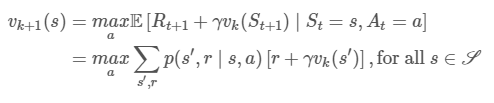

Policy Iteration과 Value Iteration의 차이점은 policy improvement가 없다는 것이다. policy iteration의 경우에는 policy에 따라 value function이 확률적으로 주어지게 된다. 따라서, 기댓값으로 value function을 구해야만 하고 Bellman expectation equation을 이용한다.

현재 policy(update중인 policy)가 optimal하다는 것을 전제하여 value function의 max값만 취하기 때문에 deterministic한 action이 된다.

In [13]:
def value_iteration(env, discount_factor = 1.0):
    
    V = np.zeros(env.observation_space.n)
    policy = np.zeros(env.observation_space.n)
    threshold = 1e-4
    
    step = 200000
    
    for i in range(step):
        delta = 0
        
        for state in range(env.observation_space.n):
            v = np.zeros(env.action_space.n)
            
            for action in range(env.action_space.n):
                q = 0
                
                for trans_prob, next_state, reward, done in env.P[state][action]:
                    q += trans_prob * (reward + discount_factor * V[next_state])
                    
                v[action] = q
            
            policy[state] = np.argmax(v)
            delta = max(delta, abs(max(v) - V[state]))
            V[state] = max(v)
        
        if delta < threshold:
            print('Policy iteration converged at step {}'.format(i+1))
            break
            
    return policy

In [14]:
env = gym.make('FrozenLake-v1', is_slippery=True)

optimal_policy = value_iteration(env,discount_factor=0.9).astype(int)
optimal_policy = optimal_policy.astype(int)
print(optimal_policy.reshape(4,4))

done = False
state = env.reset()
env.render()
while not done:
    action = optimal_policy[state]
    new_state, reward, done, info = env.step(action)
    print()
    env.render()
    state = new_state

Policy iteration converged at step 36
[[0 3 0 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]

SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG


In [15]:
def value_iteration2(env, discount_factor = 1.0):
    
    V = np.zeros(env.observation_space.n)
    policy = np.zeros(env.observation_space.n)
    threshold = 1e-4
    
    step = 200000
    
    for i in range(step):
        delta = 0
        
        for state in range(env.observation_space.n)[::-1]:
            v = np.zeros(env.action_space.n)
            
            for action in range(env.action_space.n):
                q = 0
                
                for trans_prob, next_state, reward, done in env.P[state][action]:
                    q += trans_prob * (reward + discount_factor * V[next_state])
                    
                v[action] = q
            
            policy[state] = np.argmax(v)
            delta = max(delta, abs(max(v) - V[state]))
            V[state] = max(v)
        
        if delta < threshold:
            print('Policy iteration converged at step {}'.format(i+1))
            break
            
    return policy

In [16]:
env = gym.make('FrozenLake-v1', is_slippery=True)

optimal_policy = value_iteration2(env,discount_factor=0.9).astype(int)
optimal_policy = optimal_policy.astype(int)
print(optimal_policy.reshape(4,4))

done = False
state = env.reset()
env.render()
while not done:
    action = optimal_policy[state]
    new_state, reward, done, info = env.step(action)
    print()
    env.render()
    state = new_state

Policy iteration converged at step 31
[[0 3 0 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]

SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Righ

## 하지만

Dynamic programming은 방대한 계산을 요하며 model을 알아야 한다는 점이 실제 문제를 푸는데 있어 제약이 된다. Full-width backup을 하는 것 대신, 시행착오를 겪으며 sample backup을 하는 것이 강화학습이고 이에 근간이 되는 Monte Carlo Method를 알아야 한다.